### To Run this notebook, run the following command in the terminal:
#### pip install -r requirements.txt
#### python version: 3.10.19 (recommended)

    

### Importing the libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Load the fama french data

In [2]:
import os
import re
import zipfile
from io import BytesIO

import requests

os.makedirs("data/raw", exist_ok=True)
ff5_path = "data/raw/ff5_data.csv"
local_raw_path = "F-F_Research_Data_5_Factors_2x3_daily.csv"


def _parse_ff5_daily_lines(lines):
    rows = []
    for line in lines:
        compact = "".join(line.replace("\ufeff", "").split())
        if re.match(r"^\d{8},", compact):
            parts = compact.split(",")
            if len(parts) >= 7:
                rows.append(parts[:7])

    if len(rows) == 0:
        raise RuntimeError("Could not parse any FF5 daily rows from the raw Ken French CSV.")

    df = pd.DataFrame(rows, columns=["Date", "Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"])
    for c in ["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"]:
        df[c] = pd.to_numeric(df[c], errors="coerce")

    df = df.dropna(subset=["Mkt-RF", "SMB", "HML", "RMW", "CMA", "RF"])
    return df


if not os.path.exists(ff5_path):
    if os.path.exists(local_raw_path):
        with open(local_raw_path, "r", encoding="latin-1") as f:
            raw_lines = f.read().splitlines()
        ff5_df = _parse_ff5_daily_lines(raw_lines)
    else:
        ff5_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_daily_CSV.zip"
        resp = requests.get(ff5_url, timeout=60, headers={"User-Agent": "Mozilla/5.0"})
        resp.raise_for_status()

        zf = zipfile.ZipFile(BytesIO(resp.content))
        csv_names = [n for n in zf.namelist() if n.lower().endswith(".csv")]
        if len(csv_names) == 0:
            raise RuntimeError("Ken French ZIP did not contain a CSV file.")

        daily_candidates = [n for n in csv_names if "daily" in n.lower()]
        csv_name = daily_candidates[0] if len(daily_candidates) > 0 else csv_names[0]

        raw_text = zf.read(csv_name).decode("latin-1")
        ff5_df = _parse_ff5_daily_lines(raw_text.splitlines())

    ff5_df.to_csv(ff5_path, index=False)

print("FF5 data ready:", ff5_path)

FF5 data ready: data/raw/ff5_data.csv


In [3]:
ff5_data = pd.read_csv("data/raw/ff5_data.csv")

# Convert dates, coercing errors to NaT (Not a Time)
ff5_data['Date'] = pd.to_datetime(ff5_data['Date'], format='%Y%m%d', errors='coerce')

# Remove rows where Date conversion failed
ff5_data = ff5_data.dropna(subset=['Date'])

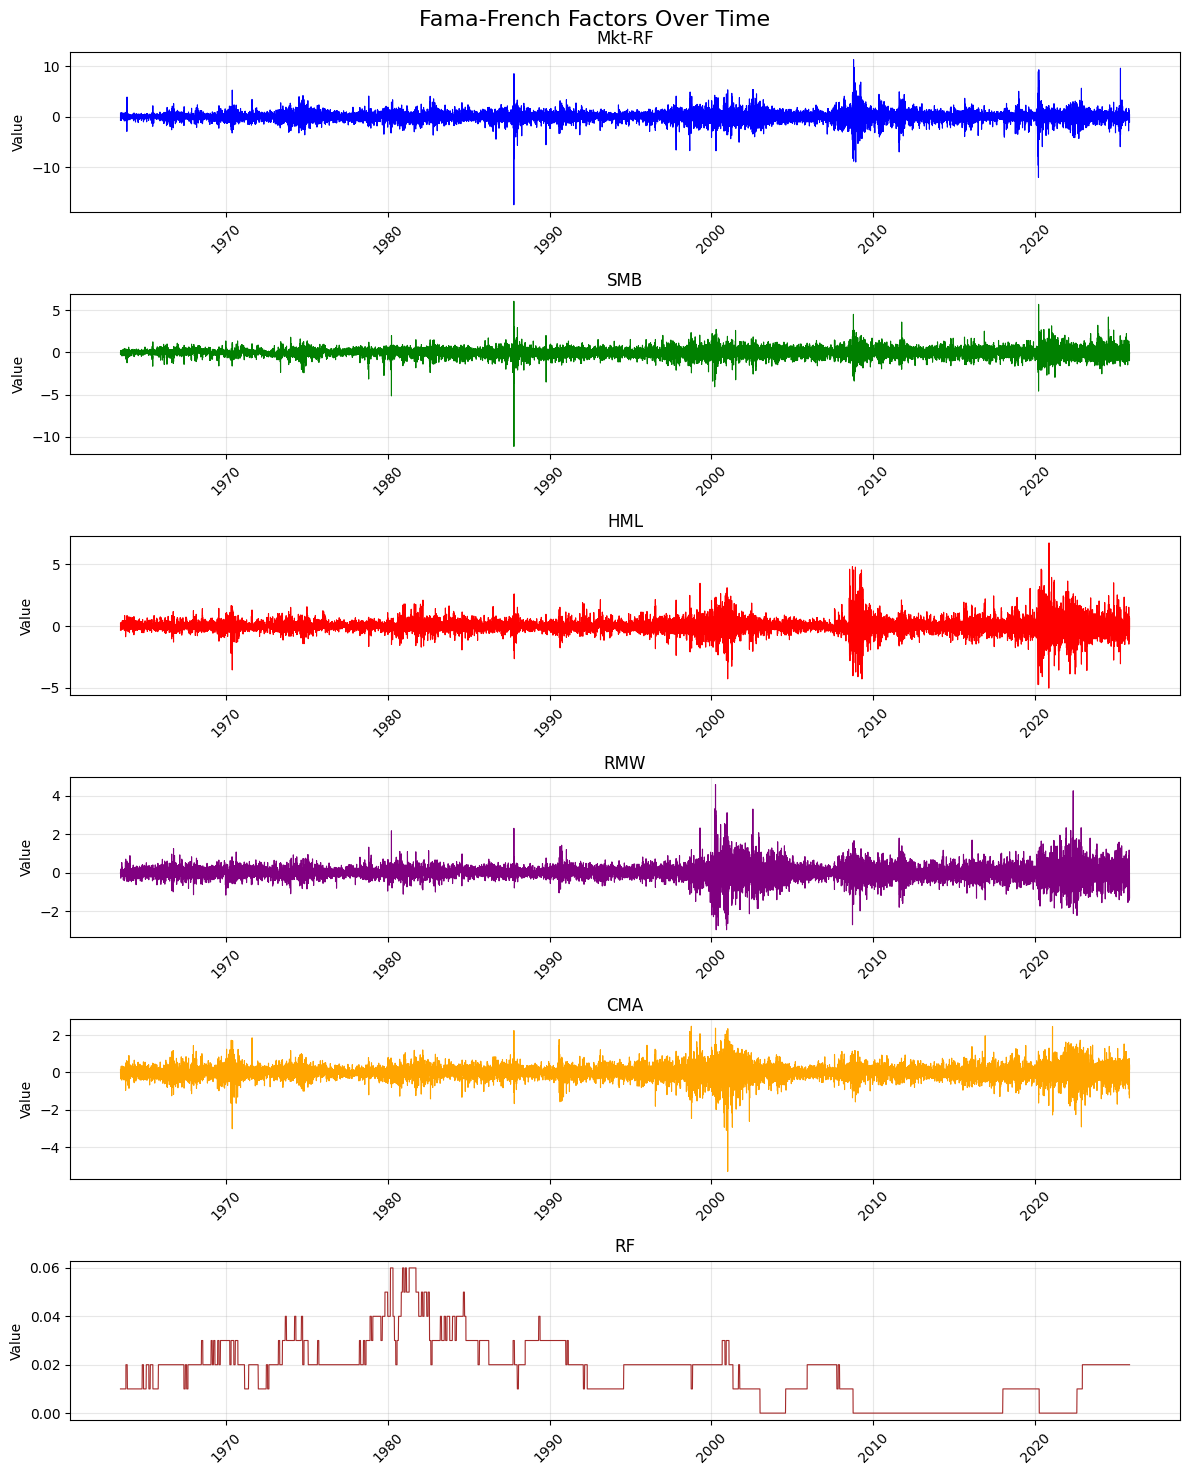

In [4]:
# Set Date as index for better plotting
ff5_data.set_index('Date', inplace=True)

# Plot each feature in subplots
features = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown']

fig, axes = plt.subplots(6, 1, figsize=(12, 15))
fig.suptitle('Fama-French Factors Over Time', fontsize=16)

for i, (feature, color) in enumerate(zip(features, colors)):
    axes[i].plot(ff5_data.index, ff5_data[feature], color=color, linewidth=0.8)
    axes[i].set_title(f'{feature}', fontsize=12)
    axes[i].set_ylabel('Value')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

### Download current S&P 500 constituents and compute monthly returns (including SPY benchmark)

In [5]:
import pandas as pd
import yfinance as yf
from datetime import datetime
import requests
from io import StringIO

url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

response = requests.get(url, headers=headers)
sp500_table = pd.read_html(StringIO(response.text))
sp500_df = sp500_table[0]

sp500_df['Symbol'] = sp500_df['Symbol'].astype(str).str.replace('.', '-', regex=False)

print("S&P 500 Companies:")
print(sp500_df.head())
print(f"\nTotal companies: {len(sp500_df)}")

tickers = sp500_df['Symbol'].tolist()


S&P 500 Companies:
  Symbol             Security             GICS Sector  \
0    MMM                   3M             Industrials   
1    AOS          A. O. Smith             Industrials   
2    ABT  Abbott Laboratories             Health Care   
3   ABBV               AbbVie             Health Care   
4    ACN            Accenture  Information Technology   

                GICS Sub-Industry    Headquarters Location  Date added  \
0        Industrial Conglomerates    Saint Paul, Minnesota  1957-03-04   
1               Building Products     Milwaukee, Wisconsin  2017-07-26   
2           Health Care Equipment  North Chicago, Illinois  1957-03-04   
3                   Biotechnology  North Chicago, Illinois  2012-12-31   
4  IT Consulting & Other Services          Dublin, Ireland  2011-07-06   

       CIK      Founded  
0    66740         1902  
1    91142         1916  
2     1800         1888  
3  1551152  2013 (1888)  
4  1467373         1989  

Total companies: 503


In [6]:
sp500_df.to_csv("data/raw/sp500.csv", index=False)

In [7]:
# Download monthly data with proper parameters
start_date = '2005-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print("=" * 60)
print("DOWNLOADING S&P 500 DATA")
print("=" * 60)

# Download SPY benchmark data - monthly
print("\n[1/2] Downloading SPY (Benchmark)...")
spy_data = yf.download(
    tickers='SPY',
    start=start_date,
    end=end_date,
    interval='1mo',
    progress=True,
    auto_adjust=True
)

# Download all S&P 500 stocks - monthly
print("\n[2/2] Downloading all S&P 500 stocks...")
price_data = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    interval='1mo',
    threads=True,
    progress=True,
    auto_adjust=True,
    group_by='column'
)

# Calculate monthly returns (with auto_adjust=True, use 'Close' not 'Adj Close')
monthly_returns = price_data['Close'].pct_change(fill_method=None)
spy_monthly_returns = spy_data['Close'].pct_change(fill_method=None)

# Standardize monthly timestamps to month-start and drop the current (incomplete) month if present
monthly_returns.index = monthly_returns.index.to_period('M').to_timestamp()
spy_monthly_returns.index = spy_monthly_returns.index.to_period('M').to_timestamp()

current_month = pd.Timestamp.today().to_period('M')
if len(monthly_returns) > 0 and monthly_returns.index.max().to_period('M') == current_month:
    monthly_returns = monthly_returns.iloc[:-1]
if len(spy_monthly_returns) > 0 and spy_monthly_returns.index.max().to_period('M') == current_month:
    spy_monthly_returns = spy_monthly_returns.iloc[:-1]

print("\n" + "=" * 60)
print("DOWNLOAD SUMMARY")
print("=" * 60)
print(f" Price data shape: {price_data.shape}")
print(f"Monthly returns shape: {monthly_returns.shape}")
print(f"Date range: {monthly_returns.index[0].strftime('%Y-%m-%d')} to {monthly_returns.index[-1].strftime('%Y-%m-%d')}")
print(f"Total months: {len(monthly_returns)}")
print(f"Successfully downloaded: {monthly_returns.shape[1]} stocks")
print("=" * 60)

DOWNLOADING S&P 500 DATA

[1/2] Downloading SPY (Benchmark)...


[*********************100%***********************]  1 of 1 completed
[*                      2%                       ]  8 of 503 completed


[2/2] Downloading all S&P 500 stocks...


[*********************100%***********************]  503 of 503 completed



DOWNLOAD SUMMARY
 Price data shape: (252, 2515)
Monthly returns shape: (251, 503)
Date range: 2005-01-01 to 2025-11-01
Total months: 251
Successfully downloaded: 503 stocks


In [8]:
monthly_returns

Ticker,A,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,ADM,...,WY,WYNN,XEL,XOM,XYL,XYZ,YUM,ZBH,ZBRA,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-02-01,0.085482,0.166711,NaN,NaN,0.027219,0.129322,-0.019194,0.085237,0.023126,-0.004132,...,0.072596,0.091672,-0.025839,0.226938,NaN,NaN,0.054695,0.089410,-0.020813,NaN
2005-03-01,-0.075000,-0.071110,NaN,NaN,0.013698,-0.034716,-0.054794,0.087773,-0.014175,0.023453,...,0.030019,-0.053514,-0.030474,-0.053990,NaN,NaN,0.062116,-0.094179,-0.047724,NaN
2005-04-01,-0.065315,-0.134629,NaN,NaN,0.054483,-0.001249,-0.101449,-0.114461,-0.056170,-0.268104,...,0.001606,-0.218482,0.012446,-0.043121,NaN,NaN,-0.093611,0.046395,0.005685,NaN
2005-05-01,0.157108,0.102607,NaN,NaN,-0.013049,0.116529,0.072811,0.113839,0.087071,0.103391,...,-0.065005,-0.115036,0.072759,-0.014554,NaN,NaN,0.094341,-0.059445,-0.108878,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-07-01,-0.027116,0.011698,0.018317,0.000529,-0.072201,-0.054805,-0.106360,-0.075450,-0.051959,0.026525,...,-0.024912,0.163980,0.087388,0.035622,0.117965,0.137347,-0.027197,0.007430,0.099429,-0.065149
2025-08-01,0.096809,0.118370,0.122724,-0.014198,0.055991,0.063560,-0.021826,-0.002768,0.118773,0.156146,...,0.032735,0.162524,-0.014297,0.023737,-0.021159,0.030805,0.019563,0.157665,-0.064686,0.076363
2025-09-01,0.021407,0.098126,0.100475,-0.069792,0.009649,-0.008740,-0.051429,-0.011074,-0.022323,-0.038115,...,-0.033929,0.014309,0.114104,-0.004295,0.044851,-0.092541,0.034225,-0.071631,-0.062853,-0.064450


In [9]:
spy_monthly_returns

Ticker,SPY
Date,
2005-01-01,NaN
2005-02-01,0.020904
2005-03-01,-0.022134
2005-04-01,-0.014881
2005-05-01,0.032224
...,...
2025-07-01,0.026056
2025-08-01,0.020520
2025-09-01,0.032757


In [10]:
# Save data as csv files
# Drop the first month created by pct_change() (typically all-NaN / NaN)
monthly_returns_to_save = monthly_returns.dropna(how="all")
monthly_returns_to_save.to_csv("data/raw/market_data.csv", index=True)

# Ensure the benchmark CSV has a consistent column name: SPY
if isinstance(spy_monthly_returns, pd.Series):
    spy_to_save = spy_monthly_returns.rename("SPY").to_frame()
else:
    spy_to_save = spy_monthly_returns.copy()
    if list(spy_to_save.columns) != ["SPY"] and spy_to_save.shape[1] == 1:
        spy_to_save.columns = ["SPY"]

# Drop the first NaN return from pct_change()
spy_to_save = spy_to_save.dropna()
spy_to_save.to_csv("data/raw/spy_monthly_returns.csv", index=True)